# Benchmark numpy based vs pycuda wrapper for nvidia's cuSolver for solving systems of linear equations of the form $AX=B$

The intention of the next experiment is to build a wrapper of the new library developed by nvidia named [cuSolver](https://developer.nvidia.com/cusolver) that implements several techniques for solve systems of linear systems for dense and saparse matrices.

Then benckmark this wrapper against the numpy's solver using the [continuum mkl aceleration](http://docs.continuum.io/mkl-optimizations/index.html) that is an accelerated version of numpy via intel's [mkl library](https://software.intel.com/en-us/intel-mkl). 

In [7]:
import numpy as np
import pycuda.gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
import time
import pycuda.gpuarray as gpuarray
import ctypes
import ctypes.util
from bokeh.plotting import *
from bokeh.palettes import *

libcusolver = ctypes.cdll.LoadLibrary('libcusolver.so')

class _types:
    handle = ctypes.c_void_p
    work = ctypes.c_void_p
    
    
libcusolver.cusolverDnCreate.restype = int
libcusolver.cusolverDnCreate.argtypes = [_types.handle]
def cusolverCreate():
    handle = _types.handle()
    libcusolver.cusolverDnCreate(ctypes.byref(handle))
    return handle.value
    
libcusolver.cusolverDnDestroy.restype = int
libcusolver.cusolverDnDestroy.argtypes = [_types.handle]
def cusolverDestroy(handle):
    libcusolver.cusolverDnDestroy(handle)
    
    
def checkStatus(status):
    if status != 0:
        raise RuntimeError('error!')
    

#helper function for LU factorization
libcusolver.cusolverDnSgetrf_bufferSize.restype = int
libcusolver.cusolverDnSgetrf_bufferSize.argtypes =[_types.handle,
                                           ctypes.c_int,
                                           ctypes.c_int,
                                           ctypes.c_void_p,
                                           ctypes.c_int,
                                           ctypes.c_void_p]
#Single precision LU factorization
libcusolver.cusolverDnSgetrf.restype = int 
libcusolver.cusolverDnSgetrf.argtypes = [_types.handle,    
                                           ctypes.c_int,
                                           ctypes.c_int,
                                           ctypes.c_void_p,
                                           ctypes.c_int,
                                           ctypes.c_void_p,
                                           ctypes.c_void_p,
                                           ctypes.c_void_p]
                                           
#Single precision LU solver
libcusolver.cusolverDnSgetrs.restype=int
libcusolver.cusolverDnSgetrs.argtypes=[_types.handle,
                                       ctypes.c_int,
                                       ctypes.c_int,
                                       ctypes.c_int,
                                       ctypes.c_void_p,
                                       ctypes.c_int,
                                       ctypes.c_void_p,
                                       ctypes.c_void_p,
                                       ctypes.c_int,
                                       ctypes.c_void_p]
         
#perform the LU factorization
def cusolverLUFactorization(handle, matrix):
    m,n=matrix.shape
    mtx_gpu = gpuarray.to_gpu(matrix.T.copy().astype('float32'))
    P_gpu = gpuarray.zeros(min(m, n), np.int32)
    info_gpu = gpuarray.zeros(1, np.int32)
    
    work = ctypes.c_int() #allocate locally
    status=libcusolver.cusolverDnSgetrf_bufferSize(handle, m, n, int(mtx_gpu.gpudata), m, ctypes.pointer(work))#get workspace
    checkStatus(status)
    work_gpu = gpuarray.empty((work.value, 1), np.float32)
    
    status=libcusolver.cusolverDnSgetrf(handle, m, n, int(mtx_gpu.gpudata) , m, int(work_gpu.gpudata) , int(P_gpu.gpudata),  int(info_gpu.gpudata))
    
    checkStatus(status)
    return mtx_gpu, P_gpu


#solve AX=B given LU factorization and pivots matrix 
def cusolverSolveLU(handle,LU,P,B):
    rows_LU ,cols_LU = LU.shape
    rows_B, cols_B = B.shape
    B_gpu = gpuarray.to_gpu(B.T.copy().astype('float32'))
    info_gpu = gpuarray.zeros(1, np.int32)
    
    status=libcusolver.cusolverDnSgetrs(handle, 0, cols_LU, cols_B, int(LU.gpudata), rows_LU, int(P.gpudata), int(B_gpu.gpudata), rows_B, int(info_gpu.gpudata))
    
    checkStatus(status)
    return B_gpu

def solveGPU_LU(A,B):
    handle_solver=cusolverCreate()#initiate cuSolve
    LU,P = cusolverLUFactorization(handle_solver,A)
    X=cusolverSolveLU(handle_solver,LU,P,B)
    cusolverDestroy(handle_solver)
    return X.get().T

################################################
#############Cholesky Factorization#############
################################################

#Helper function for Cholesky factorization
libcusolver.cusolverDnSpotrf_bufferSize.restype=int
libcusolver.cusolverDnSpotrf_bufferSize.argtypes=[_types.handle,
                                       ctypes.c_int,
                                       ctypes.c_int,
                                       ctypes.c_void_p,
                                       ctypes.c_int,    
                                       ctypes.c_void_p]
                                       
#Single precision cholesky factorization                                       
libcusolver.cusolverDnSpotrf.restype=int
libcusolver.cusolverDnSpotrf.argtypes=[_types.handle,
                                       ctypes.c_int,
                                       ctypes.c_int,
                                       ctypes.c_void_p,
                                       ctypes.c_int,
                                       ctypes.c_void_p,
                                       ctypes.c_int,
                                       ctypes.c_void_p]
#Single precision cholesky solver                                       
libcusolver.cusolverDnSpotrs.restype=int
libcusolver.cusolverDnSpotrs.argtypes=[_types.handle,
                                       ctypes.c_int,
                                       ctypes.c_int,
                                       ctypes.c_int,
                                       ctypes.c_void_p,
                                       ctypes.c_int,
                                       ctypes.c_void_p,
                                       ctypes.c_int,
                                       ctypes.c_void_p]

def cusolverCholeskyFactorization(handle, matrix):
    m,n=matrix.shape
    mtx_gpu = gpuarray.to_gpu(matrix.T.copy().astype('float32'))
    work = ctypes.c_int() #allocate locally
    status=libcusolver.cusolverDnSpotrf_bufferSize(handle, 1, m, int(mtx_gpu.gpudata), m,  ctypes.pointer(work) )
    checkStatus(status)
    work_gpu = gpuarray.empty((work.value, 1), np.float32)
    info_gpu = gpuarray.zeros(1, np.int32)
    
    status=libcusolver.cusolverDnSpotrf(handle, 1, n, int(mtx_gpu.gpudata), m, int(work_gpu.gpudata), work,  int(info_gpu.gpudata))
    
    checkStatus(status)
    return mtx_gpu
    
def cusolverCholeskySolver(handle, chol_factor, B):
    rows_chol, cols_chol=chol_factor.shape
    rows_B, cols_B=B.shape
    B_gpu = gpuarray.to_gpu(B.T.copy().astype('float32'))
    info_gpu = gpuarray.zeros(1, np.int32)
    
    status=libcusolver.cusolverDnSpotrs(handle, 1, cols_chol, cols_B ,int(chol_factor.gpudata), rows_chol, int(B_gpu.gpudata),rows_B , int(info_gpu.gpudata))
    
    checkStatus(status)
    return B_gpu

def solveGPU_Cholesky(A,B):
    handle_solver=cusolverCreate()#initiate cuSolve
    cholesky = cusolverCholeskyFactorization(handle_solver,A)
    X=cusolverCholeskySolver(handle_solver,cholesky, B)
    cusolverDestroy(handle_solver)
    return X.get().T
                                   
def get_time():
    return int(round(time.time() * 1000))
                                          
def perform_one_step(rows_A=100,cols_A=100,rows_B=100,cols_B=100,iterations_number=5):
    np_time=0
    lu_time=0
    chol_time=0
    
    for i in range (iterations_number):
        A = np.asarray(np.random.rand(rows_A, cols_A), np.float32)
        A=A.dot(A.T) #make sure that A is positive definite
        B = np.asarray(np.random.rand(rows_B, cols_B), np.float32)
        start = get_time()
        X_numpy=np.linalg.solve(A, B)
        np_time += get_time() - start
        
        start = get_time()
        X_LU=solveGPU_LU(A,B)
        lu_time+=get_time() - start
        
        start = get_time()
        X_CHOL=solveGPU_Cholesky(A,B)
        chol_time+=get_time() - start
        
    return [np_time/iterations_number,lu_time/iterations_number, chol_time/iterations_number]

In [8]:
def matrices_benchmark(cvs_fileName, matrix_type, to_rows=200,fixed_rows=150, increment=10):
    print "Rows, Columns, Avg time numpy (ms), Avg time GPU (ms)"
    try:
        arr=[]
        for i in xrange(increment,to_rows+increment,increment):
            if matrix_type== 'square':
                data=perform_one_step(rows_A=i,cols_A=i,rows_B=i,cols_B=i)
                print [i,i]+data
                arr.append([i,i]+data)
                np.savetxt(cvs_fileName, np.asarray(arr), delimiter=",")
            elif matrix_type=='assimetric':
                data=perform_one_step(rows_A=fixed_rows, cols_A=fixed_rows,rows_B=fixed_rows, cols_B=i)
                print [fixed_rows,i]+data
                arr.append([fixed_rows,i]+data)
                np.savetxt(cvs_fileName, np.asarray(arr), delimiter=",")
        
    except MemoryError as ex:
        print 'Memory Error: flooded memory'
        np.savetxt(cvs_fileName, np.asarray(arr), delimiter=",")
        
def load_and_plot(cvs_fileName, matrix_type, legend1, legend2, xlabel1, ylabel1, xlabel2, ylabel2,title1,title2):
    try:
        times= np.loadtxt(cvs_fileName, delimiter=',')
        if matrix_type=='square':
            x = times[:,0]
        elif matrix_type=='assimetric':
            x = times[:,1]
        else:
            raise NameError('matrix_type no recognized')
        y_np = times[:,2]
        y_lu= times[:,3]
        y_chol = times[:,4]
        improvement_lu=y_np/y_lu
        improvement_chol=y_np/y_chol
        output_notebook()
        p1 = figure(width=450, height=450,title=title1, x_axis_label=xlabel1, y_axis_label=ylabel1)
        colors = brewer["Spectral"][11]
        
        p1.line(x, y_np, legend=legend1[0], line_width=2, line_color=colors[0])
        p1.line(x, y_lu, legend=legend1[1], line_width=2, line_color=colors[2])
        p1.line(x, y_chol, legend=legend1[2], line_width=2, line_color=colors[8])
        p1.legend.orientation = "top_left"
        p1.ygrid.band_fill_color="black"
        p1.ygrid.band_fill_alpha = 0.05
        p1.grid.grid_line_alpha=0.5
        
        p2 = figure(width=500, height=450,title=title2, x_axis_label=xlabel2, y_axis_label=ylabel2,
                   x_range=p1.x_range)
        p2.line(x, improvement_lu,  legend=legend2[0], line_width=2, line_color=colors[2])
        p2.line(x, improvement_chol,  legend=legend2[1], line_width=2, line_color=colors[8])
        p2.legend.orientation = "top_left"
        p2.ygrid.band_fill_color="black"
        p2.ygrid.band_fill_alpha = 0.05
        p2.grid.grid_line_alpha=0.5
        
        p = gridplot([[p1, p2]], toolbar_location='above')
        show(p)
        
    except IOError as ex:
        print ex, "performing benchmark..."
        matrices_benchmark(cvs_fileName, matrix_type, to_rows=10000, increment=50)
        load_and_plot(cvs_fileName, matrix_type, legend1, legend2, xlabel1, ylabel1, xlabel2, ylabel2,title1,title2)
        
    
    

##Squared matrices benchmark using LU factorization

Below shows the performance comparation between the numpy solver vs. nvidia cusolver wraper using squared matrices that's it $A, B$ both have dimensions of $n \times n$ 


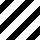
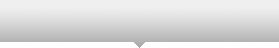
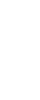
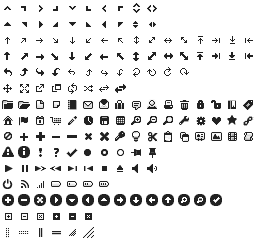
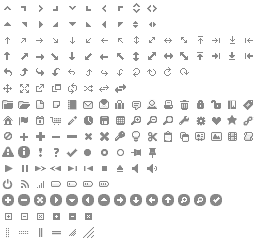
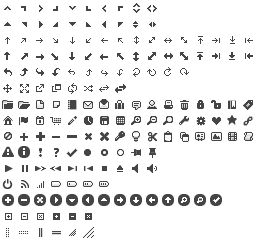
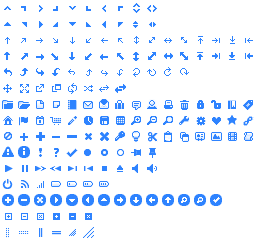
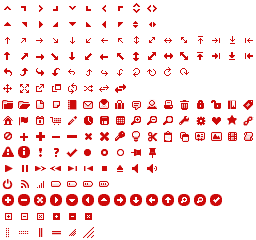
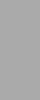
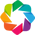
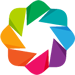
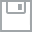
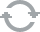
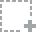
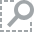
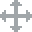
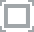
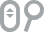

In [9]:
perform_one_step()#warmup

load_and_plot('solv_squared_gtx770.csv','square',
              ['numpy+mkl', 'LU solver','Cholesky solver'],['LU improvement', 'Cholesky improvement'],
             'matrix size','time (ms)','matrix size','Ratio',
             'Numpy solver vs. gpu solvers',
             'Improvements over Numpy')# GPU geforce gtx 770

##Assimetric matrices benchmark using LU factorization

Next perform the experiment using $B$ as an assimetric matrix; $B$ of dimensions ($nxm$), with $A$ squared matrix of size 1200x1200 that is the point when both implementations are equivalent for this hardware architecture


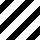
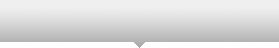
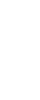
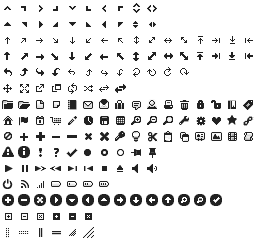
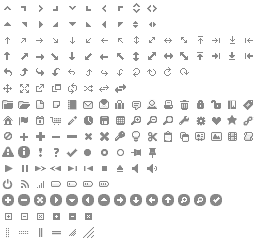
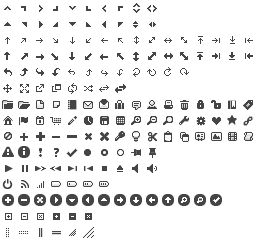
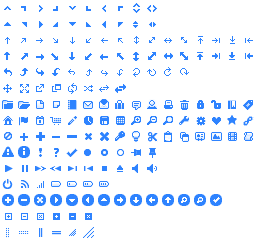
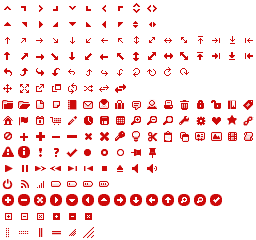
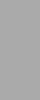
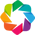
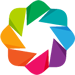
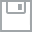
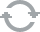
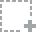
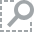
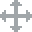
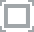
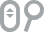

In [11]:
load_and_plot('solv_assimetric_gtx770.csv','assimetric',
              ['numpy+mkl', 'LU solver','Cholesky solver'],['LU improvement', 'Cholesky improvement'],
             'matrix size','time (ms)','matrix size','Ratio',
             'Numpy solver vs. gpu solvers',
             'Improvements over Numpy')# GPU geforce gtx 770